In [ ]:
import os
import json
import argparse
import torch
import random
import numpy as np
from datetime import datetime
from torch.utils.data import TensorDataset, DataLoader
from dataloader.dataloader import CreateLoaders
import torch.nn as nn
from models.mnf_models import MNFNet_v3,MLP
import pandas as pd
from pickle import load
import matplotlib.pyplot as plt

config = json.load(open(r"\path\to\default_config.json"))
config

In [3]:
pandas_df = pd.read_csv(config['dataset']['path_to_csv'],sep=',',index_col=None)
# These are all features in the dataset
# Only 15 are used but the others are useful for analysis and comparison
pandas_df.columns
print(len(pandas_df))

12427320


In [108]:
pandas_df.columns

Index(['has_isr', 'has_fsr', 'tower_sum_40', 'n_towers_40',
       'eta_pho_closest_to_ebeam', 'e_pho_closest_to_ebeam',
       'phi_pho_closest_to_ebeam', 'obs_x[0]', 'obs_x[1]', 'obs_x[2]',
       'obs_x[3]', 'obs_x[4]', 'obs_x[5]', 'obs_x[6]', 'obs_x[7]', 'obs_x[8]',
       'obs_y[0]', 'obs_y[1]', 'obs_y[2]', 'obs_y[3]', 'obs_y[4]', 'obs_y[5]',
       'obs_y[6]', 'obs_y[7]', 'obs_y[8]', 'obs_Q2[0]', 'obs_Q2[1]',
       'obs_Q2[2]', 'obs_Q2[3]', 'obs_Q2[4]', 'obs_Q2[5]', 'obs_Q2[6]',
       'obs_Q2[7]', 'obs_Q2[8]', 'from_tlv_gen_Q2', 'from_tlv_gen_x',
       'from_tlv_gen_y', 'obs_e_e', 'obs_e_pz', 'obs_e_pt', 'obs_e_phi',
       'obs_hfs_e', 'obs_hfs_pz', 'obs_hfs_pt', 'obs_hfs_phi', 'obs_dphi',
       'Empz', 'obs_e_trk_e', 'beam_e_e', 'obs_hfs_Empz', 'obs_e_Empz',
       'obs_event_Empz', 'rot_pt1', 'rot_pt2', 'rot_Empz1', 'rot_Empz2',
       'gen_log_x', 'gen_log_y', 'gen_log_Q2', 'e_ecal_over_trk_ratio',
       'dphi_pho_closest_to_ebeam', 'has_norad', 'obs_ptbal', 'obs_pzbal']

# Load in the inference file.

In [4]:
# If youve stored the data load it in as follows for plotting below.

# Full Test Results for H1, note you need to set the MLP path here as well.
file_path = r'path\to\inference.csv'
total_dataframe = pd.read_csv(file_path,sep=',',index_col=None)
mypreds_r = total_dataframe[['x_mlp','Q2_mlp','y_mlp']].values
mypreds_r_MNF = total_dataframe[['x','Q2','y']].values
epistemic = total_dataframe[['x_epistemic','Q2_epistemic','y_epistemic']].values
aleatoric = total_dataframe[['x_aleatoric','Q2_aleatoric','y_aleatoric']].values
Y_r_test = total_dataframe[['x_true_MLP','Q2_true_MLP','y_true_MLP','x_true_MNF','Q2_true_MNF','y_true_MNF']].values
GY_test = total_dataframe['tlv_gen_y'].values

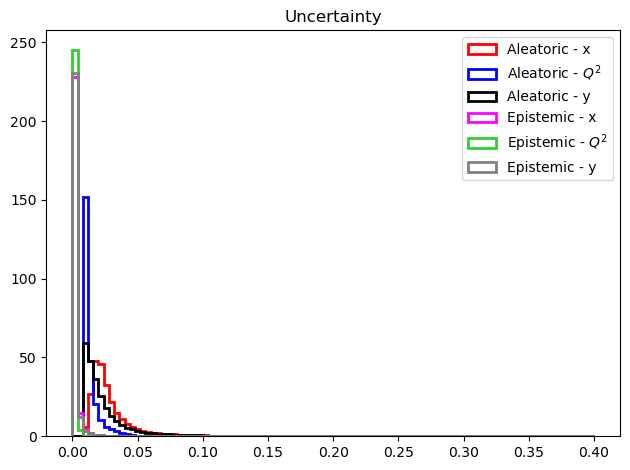

In [5]:
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.autolayout': True})

#plt.hist(mypreds_r_MNF_std[:,0],bins=100,color='blue',alpha=0.5,label='Epistemic',density=True)
plt.hist(aleatoric[:,0],range=[0,0.4],bins=100,color='red',lw=2,alpha=1.,label='Aleatoric - x',density=True,histtype='step')
plt.hist(aleatoric[:,1],range=[0,0.4],bins=100,color='blue',lw=2,alpha=1.,label=r'Aleatoric - $Q^2$',density=True,histtype='step')
plt.hist(aleatoric[:,2],range=[0,0.4],bins=100,color='black',lw=2,alpha=1.,label='Aleatoric - y',density=True,histtype='step')

plt.hist(epistemic[:,0],range=[0,0.4],bins=100,color='magenta',lw=2,linestyle='-',alpha=1.,label='Epistemic - x',density=True,histtype='step')
plt.hist(epistemic[:,1],range=[0,0.4],bins=100,color='limegreen',lw=2,linestyle='-',alpha=1.,label=r'Epistemic - $Q^2$',density=True,histtype='step')
plt.hist(epistemic[:,2],range=[0,0.4],bins=100,color='grey',lw=2,linestyle='-',alpha=1.,label='Epistemic - y',density=True,histtype='step')
plt.title("Uncertainty")
#plt.yscale('symlog')
plt.legend(loc='best')
plt.show()
plt.close()

In [8]:
# Import you scalers back in. 
z_scaler = load(open(os.path.join(config['scalers']['MLP'],"input_scaler.pkl"),'rb'))
z_scalerY = load(open(os.path.join(config['scalers']['MLP'],"target_scaler.pkl"),'rb'))

scaler = load(open(os.path.join(config['scalers']['MNF'],"input_scaler.pkl"),'rb'))
scalerY = load(open(os.path.join(config['scalers']['MNF'],"target_scaler.pkl"),'rb'))           

In [9]:
# Inverse scale
inv_trans_Y = scalerY.inverse_transform(Y_r_test[:,3:])
inv_trans_pred = scalerY.inverse_transform(mypreds_r_MNF)

pred_vals = np.exp(inv_trans_pred)
true_vals = np.exp(inv_trans_Y)

MLP_inv_trans_vals = z_scalerY.inverse_transform(mypreds_r)
MLP_pred_vals = np.exp( MLP_inv_trans_vals)

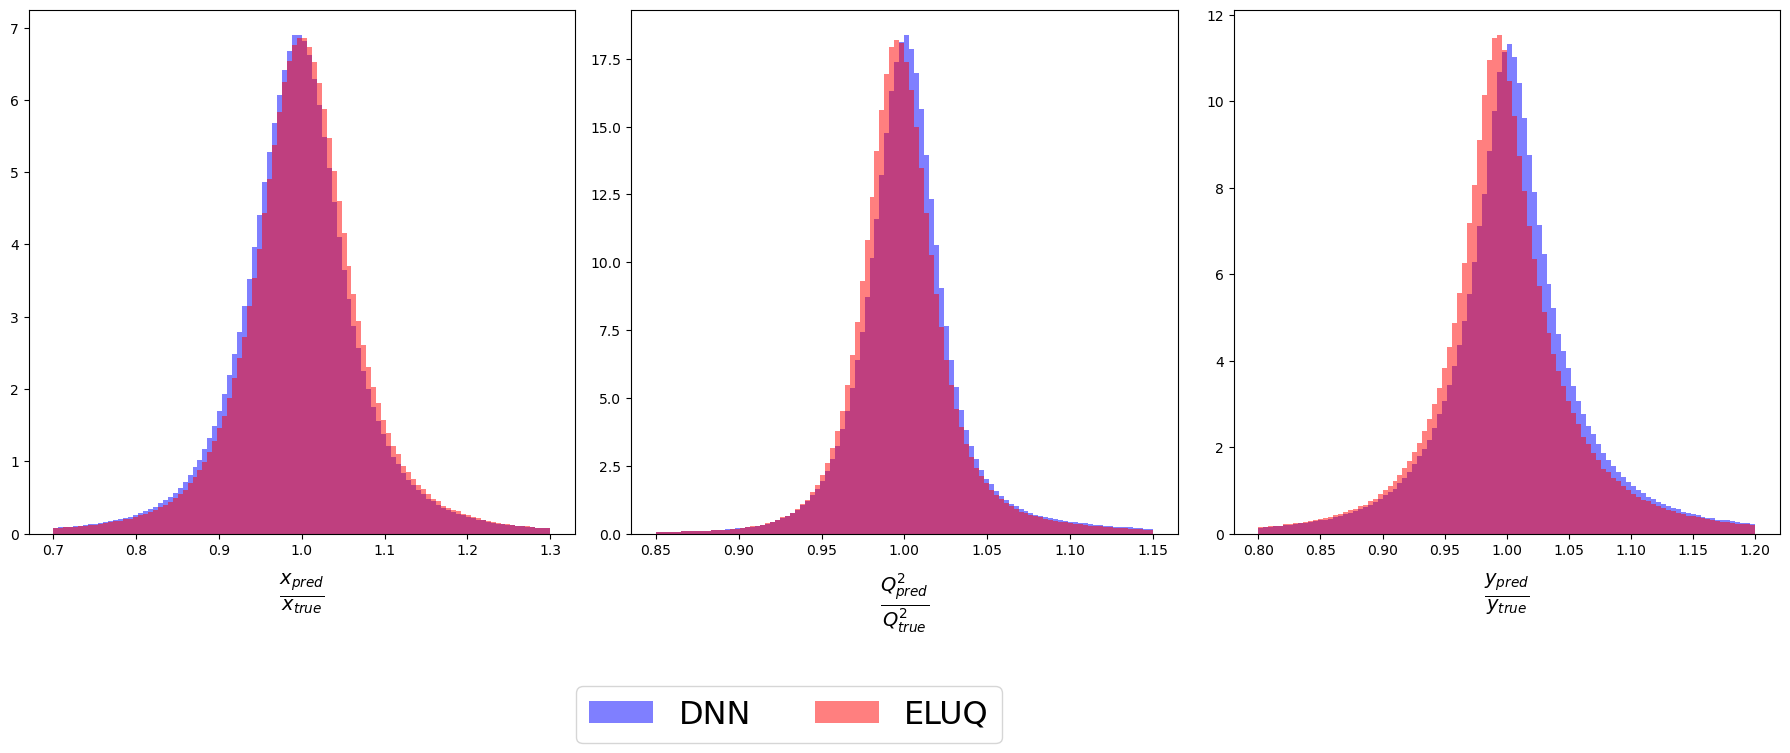

In [12]:
import matplotlib.pyplot as plt 

fig,ax = plt.subplots(1,3,figsize=(18,8))
ax[0].hist(MLP_pred_vals[:,0]/true_vals[:,0],bins=100, range=[.7,1.3] ,label='DNN',color='blue',alpha=0.5,density=True)
ax[1].hist(MLP_pred_vals[:,1]/true_vals[:,1],bins=100, range=[.85,1.15] ,label='DNN',color='blue',alpha=0.5,density=True)
ax[2].hist(MLP_pred_vals[:,2]/true_vals[:,2],bins=100, range=[.8,1.2] ,label='DNN',color='blue',alpha=0.5,density=True)
ax[0].hist(pred_vals[:,0]/true_vals[:,0],bins=100, range=[.7,1.3] ,label=r'ELUQ',color='red',alpha=0.5,density=True)
ax[1].hist(pred_vals[:,1]/true_vals[:,1],bins=100, range=[.85,1.15] ,label=r'ELUQ',color='red',alpha=0.5,density=True)
ax[2].hist(pred_vals[:,2]/true_vals[:,2],bins=100, range=[.8,1.2],label=r'ELUQ',color='red',alpha=0.5,density=True)
ax[1].legend(loc=(-.1,-.4),fontsize=23,ncol=2)
ax[1].set_xlabel(r"$\frac{Q^2_{pred}}{Q^2_{true}}$",fontsize=20,labelpad=10)
ax[2].set_xlabel(r"$\frac{y_{pred}}{y_{true}}$",fontsize=20,labelpad=10)
ax[0].set_xlabel(r"$\frac{x_{pred}}{x_{true}}$",fontsize=20,labelpad=10)
plt.show()

# Resolution in X

Some very basic example plotting code below.

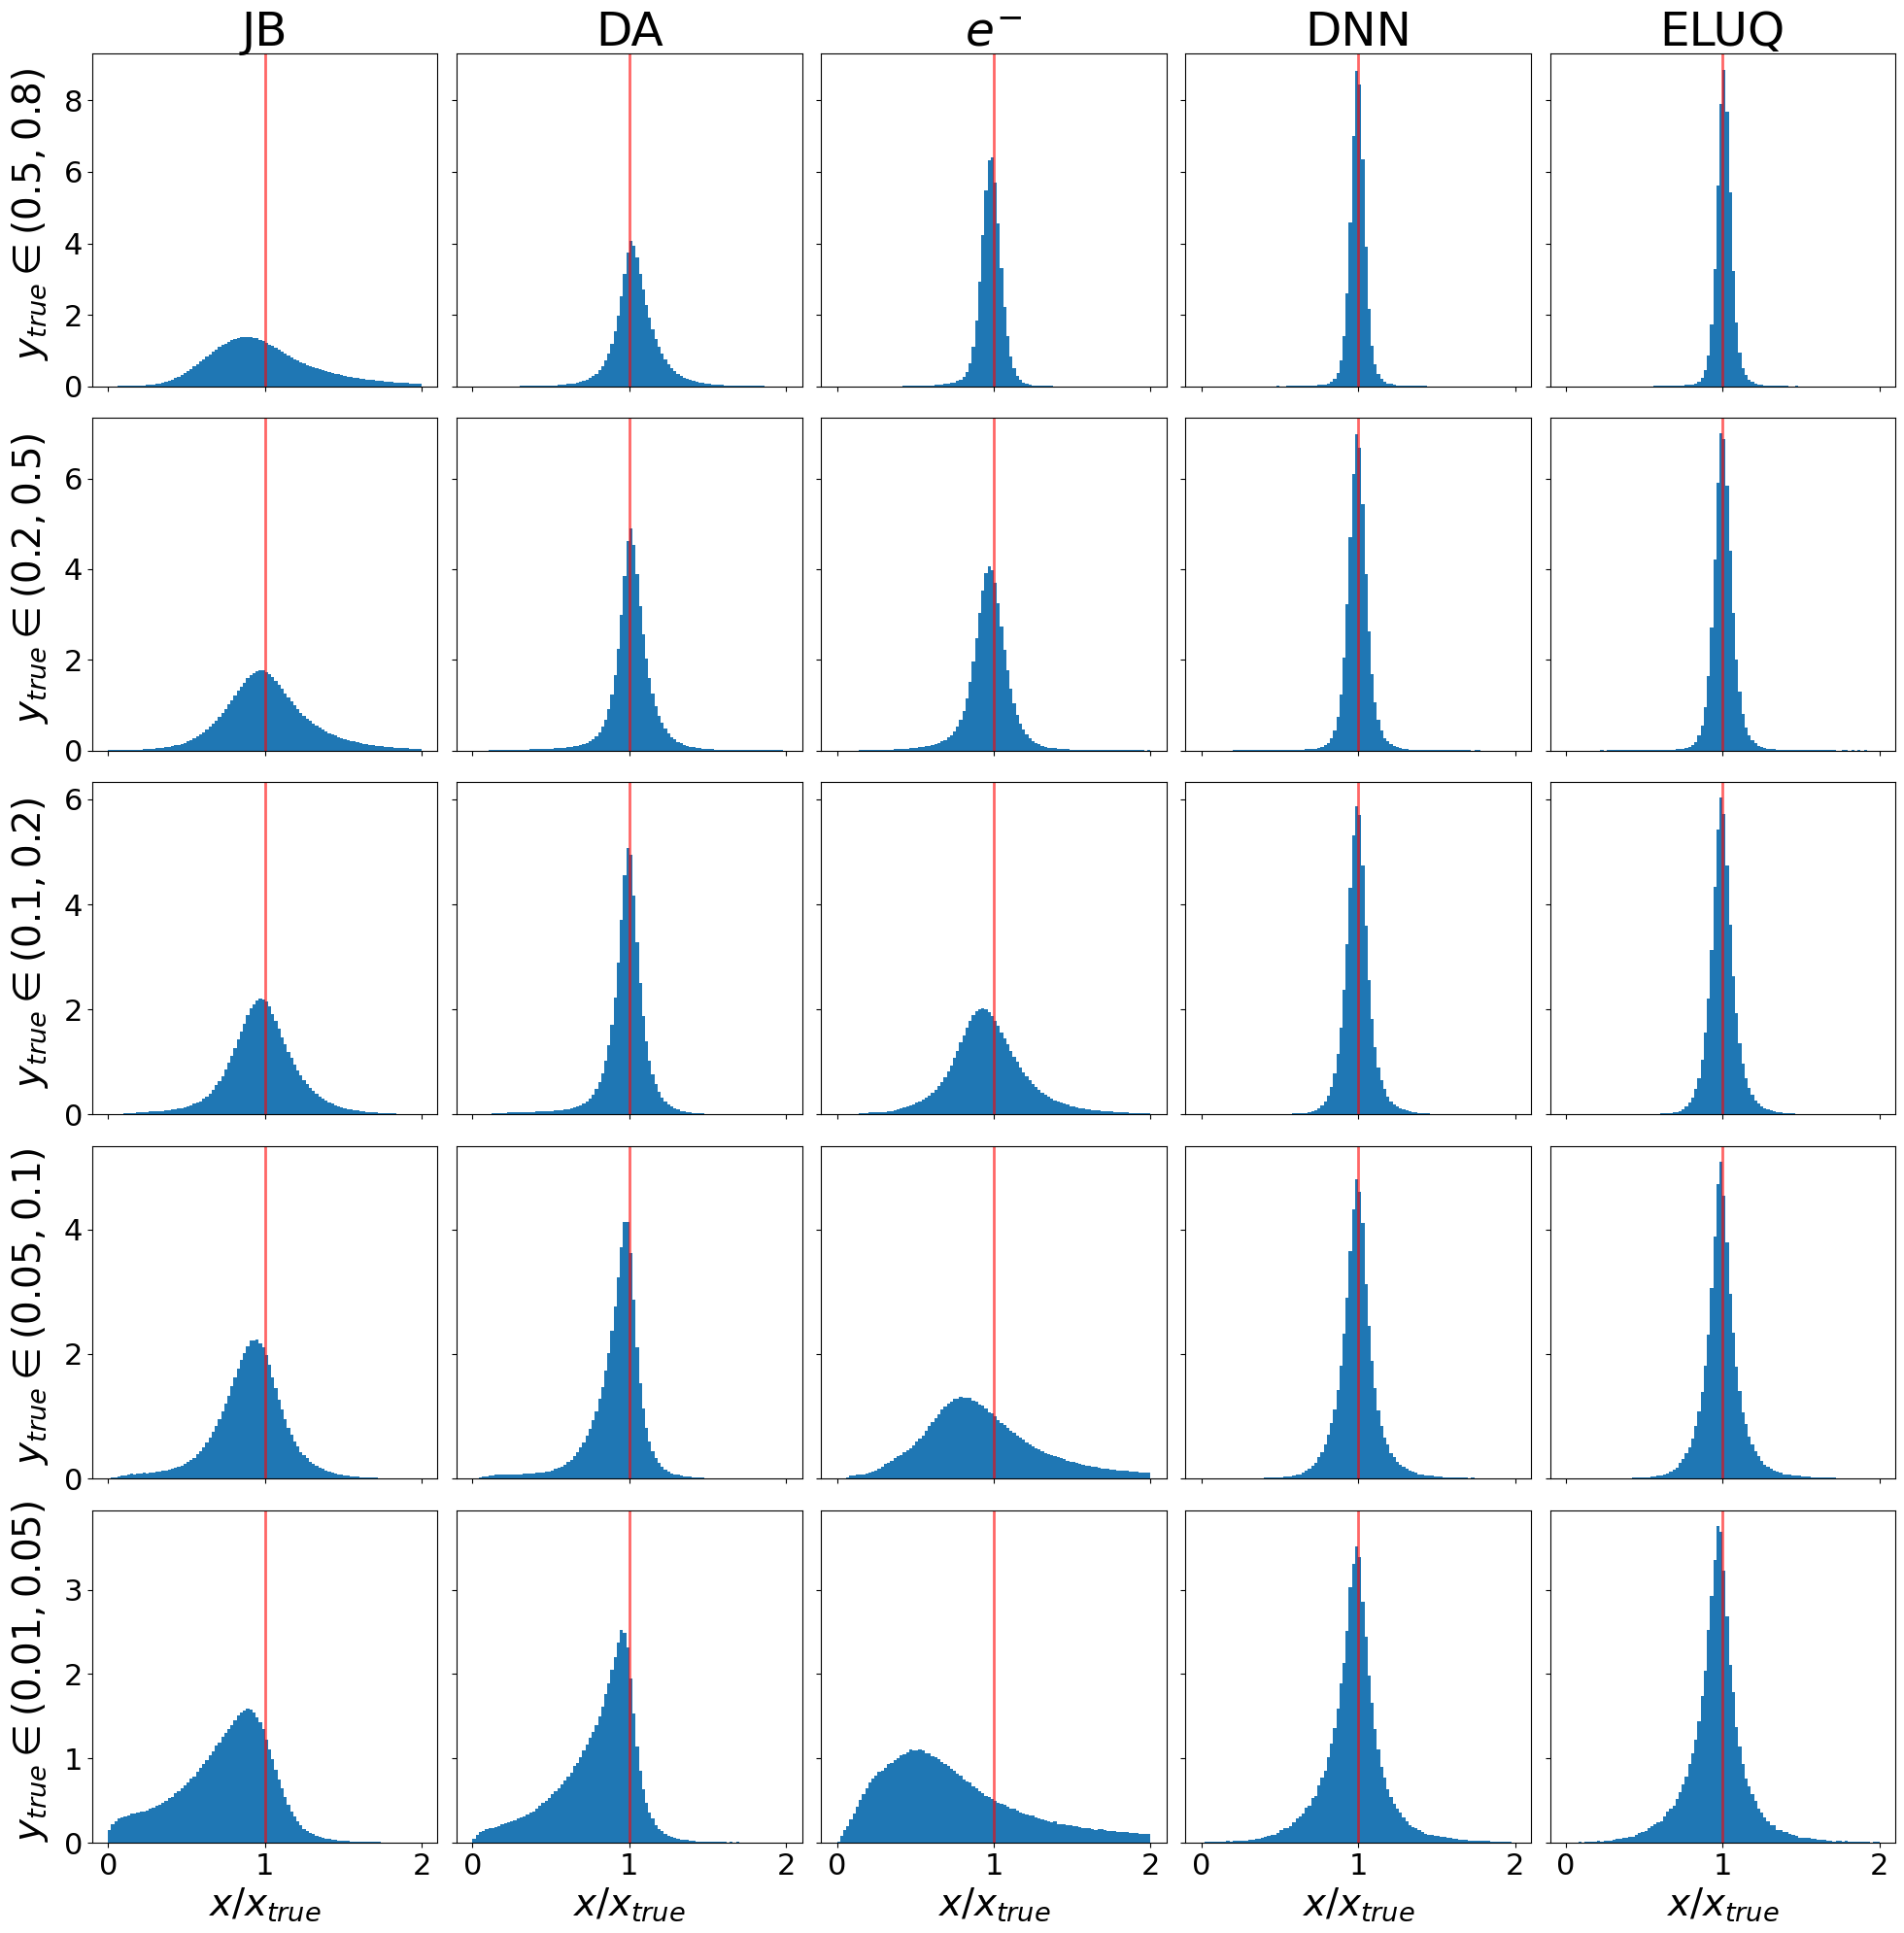

In [13]:
import matplotlib.pyplot as plt 

y_ranges = [ (0.5, 0.8), (0.2, 0.5), (0.1, 0.2), (0.05, 0.1), (0.01, 0.05)] #---previously defined

mean_xratio = []
rms_xratio = []
density = True

def cal_mean_rms(bin_edges,counts, mean_l, rms_l):
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    mean = np.average(bin_centers,weights=counts)
    rms = np.sqrt(np.average((bin_centers - mean) ** 2, weights=counts))
    mean_l.append(mean)
    rms_l.append(rms)
    return mean_l, rms_l

methods_to_use = [4, 3, 0] # [5, 4, 3, 0]
methods_labels = ['JB', 'DA', r'$e^{-}$', r'MNF','MLP'] #'I$\Sigma$ method', 'Jacquet-Blondel', 'DA method', 'e method', 'Deep NN'
# H1 Values
xmin = 0.0
xmax = 2.0


# Athena Values
# xmin = 0.75
# xmax = 1.25
y_cut = ['from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80','from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50','from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20','from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10','from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05']

fig, ax = plt.subplots(len(y_cut), len(methods_labels), figsize=(20, 20), sharey='row', sharex=True)


# the standard methods
for i in range(len(methods_to_use)):
    mi = methods_to_use[i]
    for yi in range(len(y_cut)):
        counts, bin_edges, _ = ax[yi][i].hist(pandas_df.query(y_cut[yi])['obs_x[%d]' % mi] / pandas_df.query(y_cut[yi])['from_tlv_gen_x'],
                       density=density, bins=100, range=(xmin, xmax))
        if(yi==0):
            ax[yi][i].set_title(methods_labels[i],fontsize=35)

        mean_xratio, rms_xratio= cal_mean_rms(bin_edges,counts, mean_xratio, rms_xratio)



# MLP
for yi in range(len(y_cut)):
    counts, bin_edges, _ = ax[yi][len(methods_to_use)].hist(MLP_pred_vals[:, 0][(GY_test > y_ranges[yi][0]) * (GY_test < y_ranges[yi][1])] / true_vals[:, 0][(GY_test > y_ranges[yi][0]) * (GY_test < y_ranges[yi][1])],
                   density=density, bins=100, range=(xmin, xmax))
    ax[0][len(methods_to_use)].set_title('DNN',fontsize=35)

    mean_xratio, rms_xratio= cal_mean_rms(bin_edges,counts, mean_xratio, rms_xratio)
        
# the MNF method
for yi in range(len(y_cut)):
    counts, bin_edges, _ = ax[yi][len(methods_to_use)+1].hist(pred_vals[:, 0][(GY_test > y_ranges[yi][0]) * (GY_test < y_ranges[yi][1])] / true_vals[:, 0][(GY_test > y_ranges[yi][0]) * (GY_test < y_ranges[yi][1])],
                   density=density, bins=100, range=(xmin, xmax))
    ax[0][len(methods_to_use)+1].set_title(r'ELUQ',fontsize=35)

    mean_xratio, rms_xratio= cal_mean_rms(bin_edges,counts, mean_xratio, rms_xratio)  
    
    

for yi, y_range in enumerate(y_ranges):
    ax[yi][0].set_ylabel(f' $y_{{true}} \in ({y_range[0]}, {y_range[1]})$',fontsize=28,labelpad=10)

if(len(y_cut)>0):
    for i in range(len(methods_to_use)+2):
        ax[len(y_cut)-1][i].set_xlabel('$x/x_{true}$',fontsize=28)

for i in range(len(y_cut)):
    for j in range(len(methods_to_use)+2): # +1 to include DNN
        ax[i][j].axvline(1.0, color='red', lw=2, alpha=0.6)
        ax[i][j].tick_params(axis='y', labelsize=22)
        ax[i][j].tick_params(axis='x', labelsize=22)


plt.subplots_adjust(wspace=0.1, hspace=0.1)
#plt.savefig("\save\path", format="pdf")
plt.show()

# Resolution in Q2

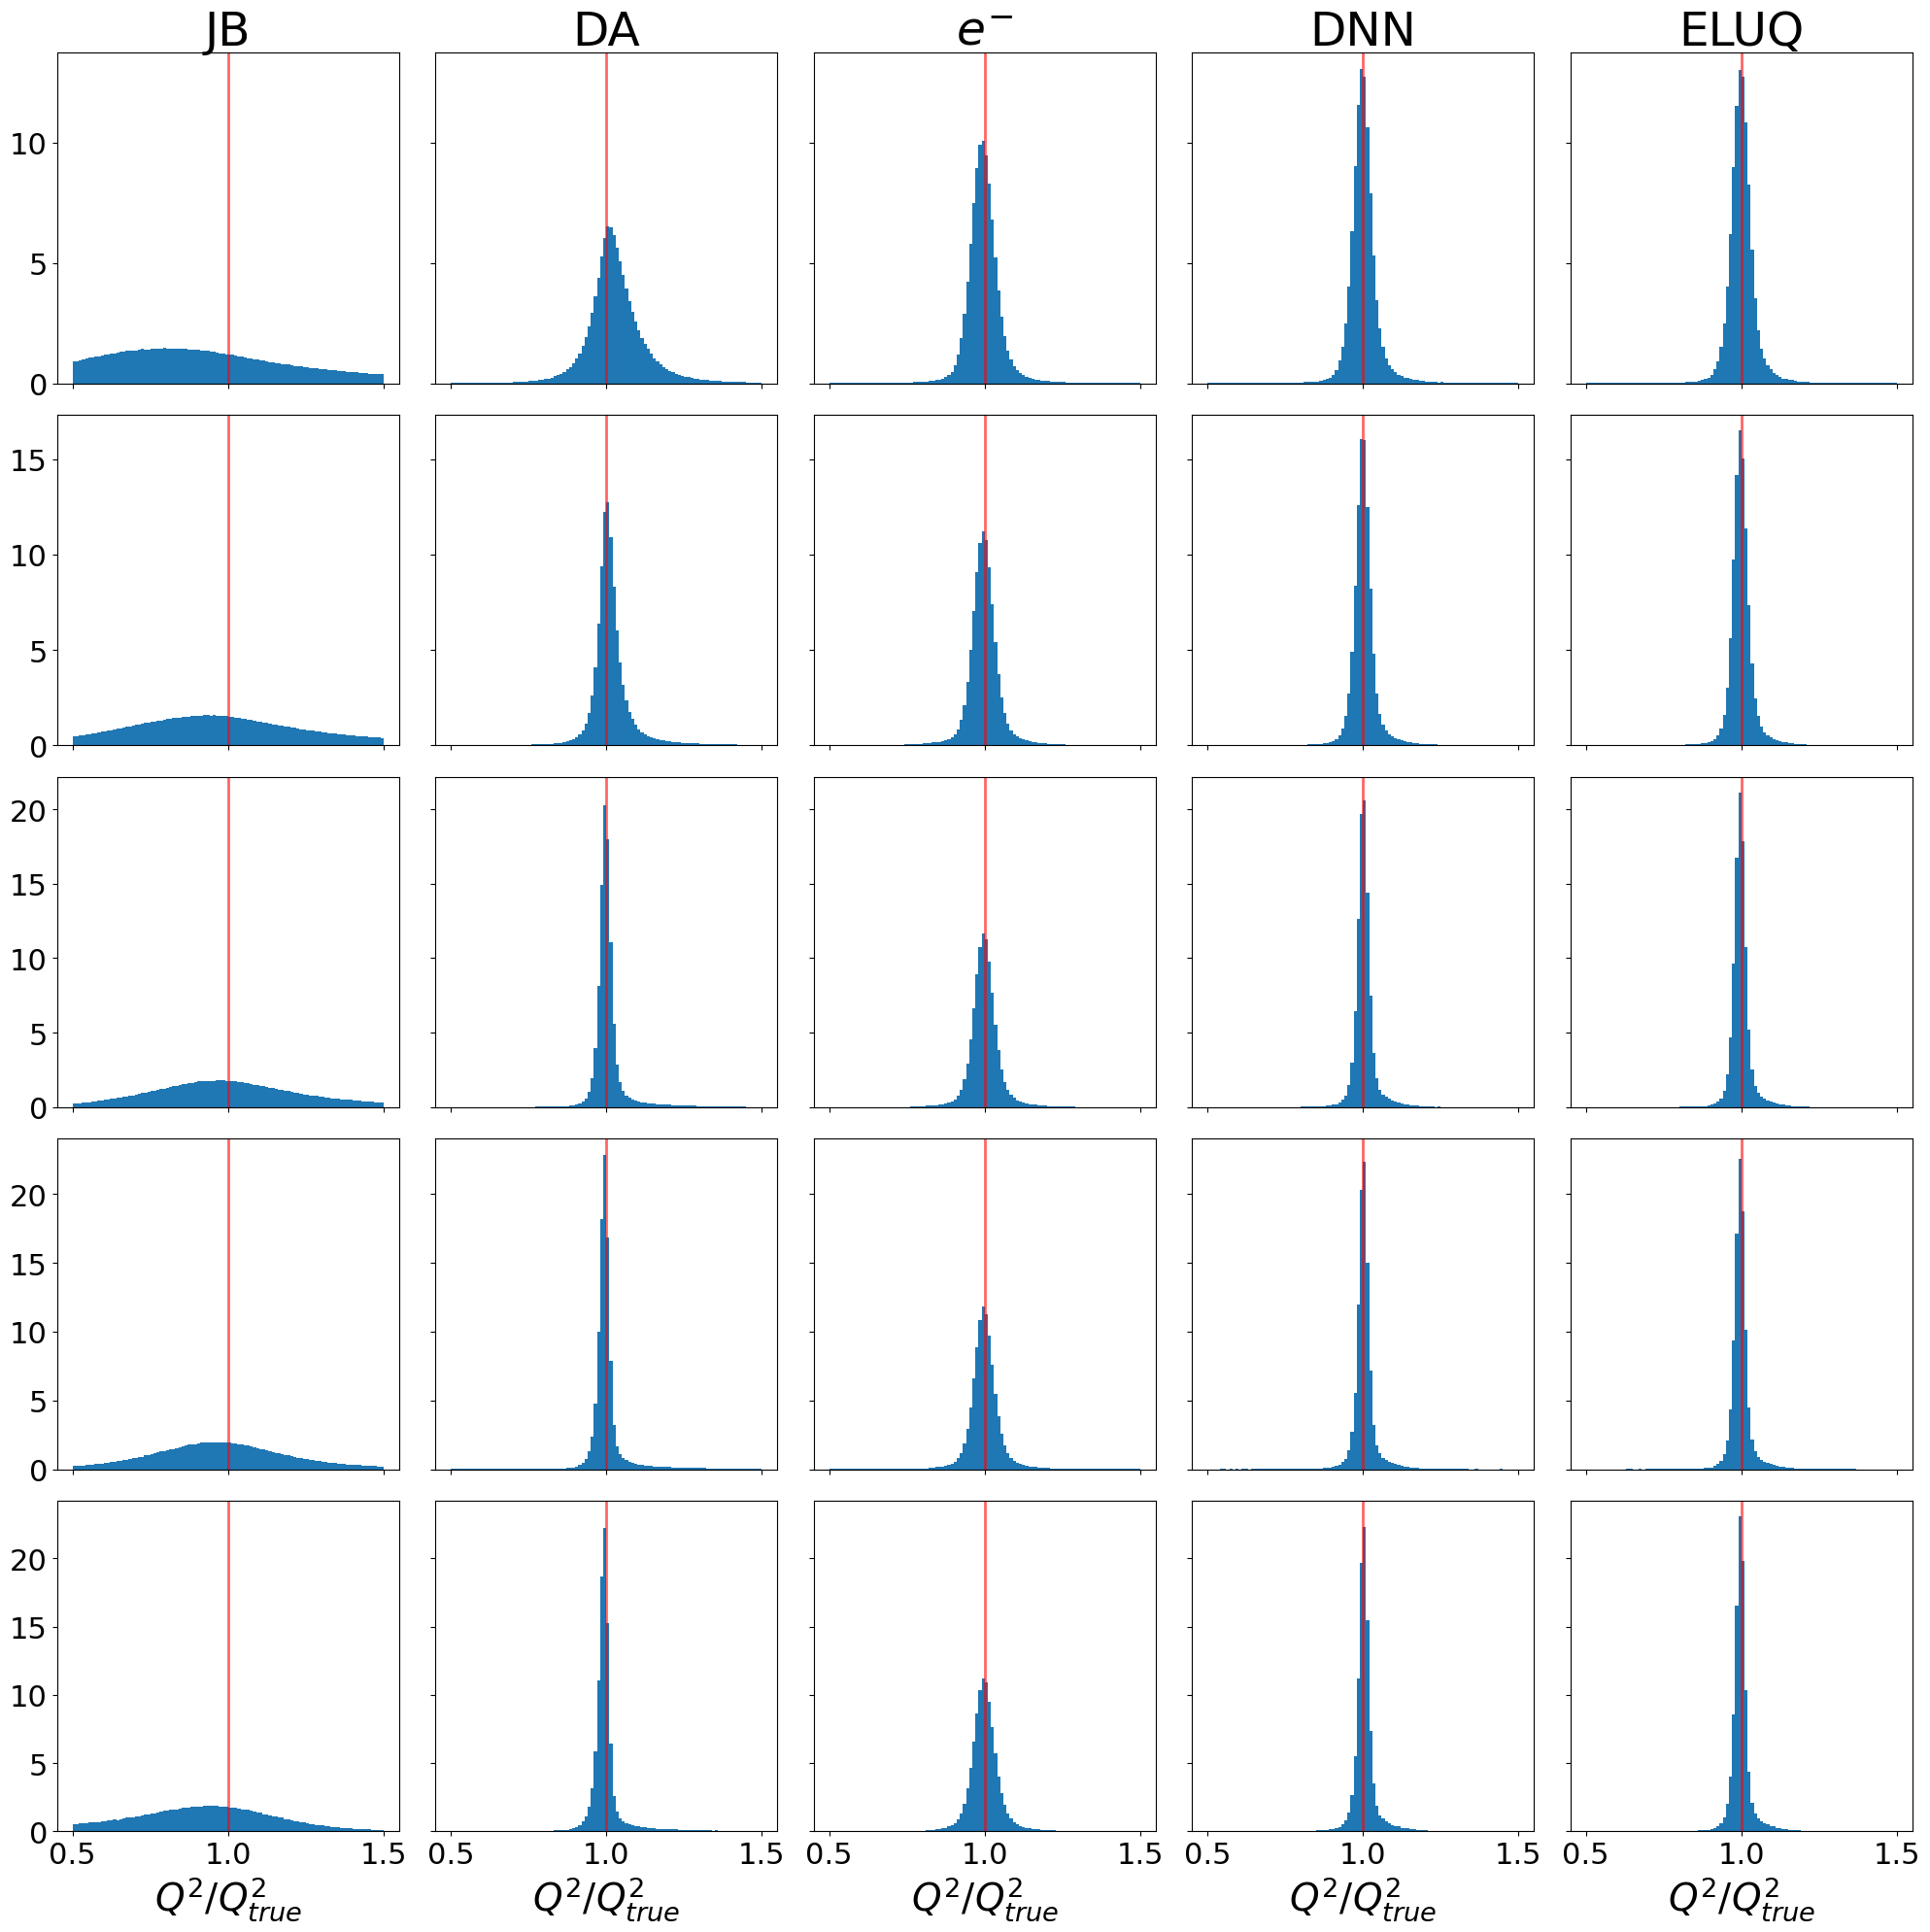

In [14]:
# y_ranges = [ (0.5, 0.8), (0.2, 0.5), (0.1, 0.2), (0.05, 0.1), (0.01, 0.05)] #---previously defined


mean_Q2ratio = []
rms_Q2ratio = []

methods_to_use = [4, 3, 0] # [5, 4, 3, 0]
methods_labels = ['JB', 'DA', r'$e^{-}$', 'MNF','MLP'] #'I$\Sigma$ method', 'Jacquet-Blondel', 'DA method', 'e method', 'Deep NN'
#H1 Values
xmin = 0.5
xmax = 1.5

# Athena Values
#xmin = 0.9
#xmax = 1.1
y_cut = ['from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80','from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50','from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20','from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10','from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05']

fig, ax = plt.subplots(len(y_cut), len(methods_labels), figsize=(20, 20), sharey='row', sharex=True)


# the standard methods
for i in range(len(methods_to_use)):
    mi = methods_to_use[i]
    for yi in range(len(y_cut)):
        counts, bin_edges, _ = ax[yi][i].hist(pandas_df.query(y_cut[yi])['obs_Q2[%d]' % mi] / pandas_df.query(y_cut[yi])['from_tlv_gen_Q2'],
                       density=True, bins=100, range=(xmin, xmax))
        if(yi==0):
          ax[yi][i].set_title(methods_labels[i],fontsize=35)

        mean_Q2ratio, rms_Q2ratio= cal_mean_rms(bin_edges,counts, mean_Q2ratio, rms_Q2ratio)


        
# the MLP method
for yi in range(len(y_cut)):
    counts, bin_edges, _ =  ax[yi][len(methods_to_use)].hist(MLP_pred_vals[:, 1][(GY_test > y_ranges[yi][0]) * (GY_test < y_ranges[yi][1])] / true_vals[:, 1][(GY_test > y_ranges[yi][0]) * (GY_test < y_ranges[yi][1])],
                   density=True, bins=100, range=(xmin, xmax))
    ax[0][len(methods_to_use)].set_title(r'DNN',fontsize=35)

    mean_Q2ratio, rms_Q2ratio= cal_mean_rms(bin_edges,counts, mean_Q2ratio, rms_Q2ratio)
    
# the MNF method
for yi in range(len(y_cut)):
    counts, bin_edges, _ =  ax[yi][len(methods_to_use)+1].hist(pred_vals[:, 1][(GY_test > y_ranges[yi][0]) * (GY_test < y_ranges[yi][1])] / true_vals[:, 1][(GY_test > y_ranges[yi][0]) * (GY_test < y_ranges[yi][1])],
                   density=True, bins=100, range=(xmin, xmax))
    ax[0][len(methods_to_use)+1].set_title(r'ELUQ',fontsize=35)

    mean_Q2ratio, rms_Q2ratio= cal_mean_rms(bin_edges,counts, mean_Q2ratio, rms_Q2ratio)

if(len(y_cut)>0):
    for i in range(len(methods_to_use)+2):
        ax[len(y_cut)-1][i].set_xlabel('$Q^2/Q^2_{true}$',fontsize=28)

for i in range(len(y_cut)):
    for j in range(len(methods_to_use)+2): # +1 to include DNN
        ax[i][j].axvline(1.0, color='red', lw=2, alpha=0.6)
        ax[i][j].tick_params(axis='y', labelsize=22)
        ax[i][j].tick_params(axis='x', labelsize=22)



plt.subplots_adjust(wspace=0.1, hspace=0.1)
#plt.savefig("save\path", format="pdf")
plt.show()

# Resolution in Y

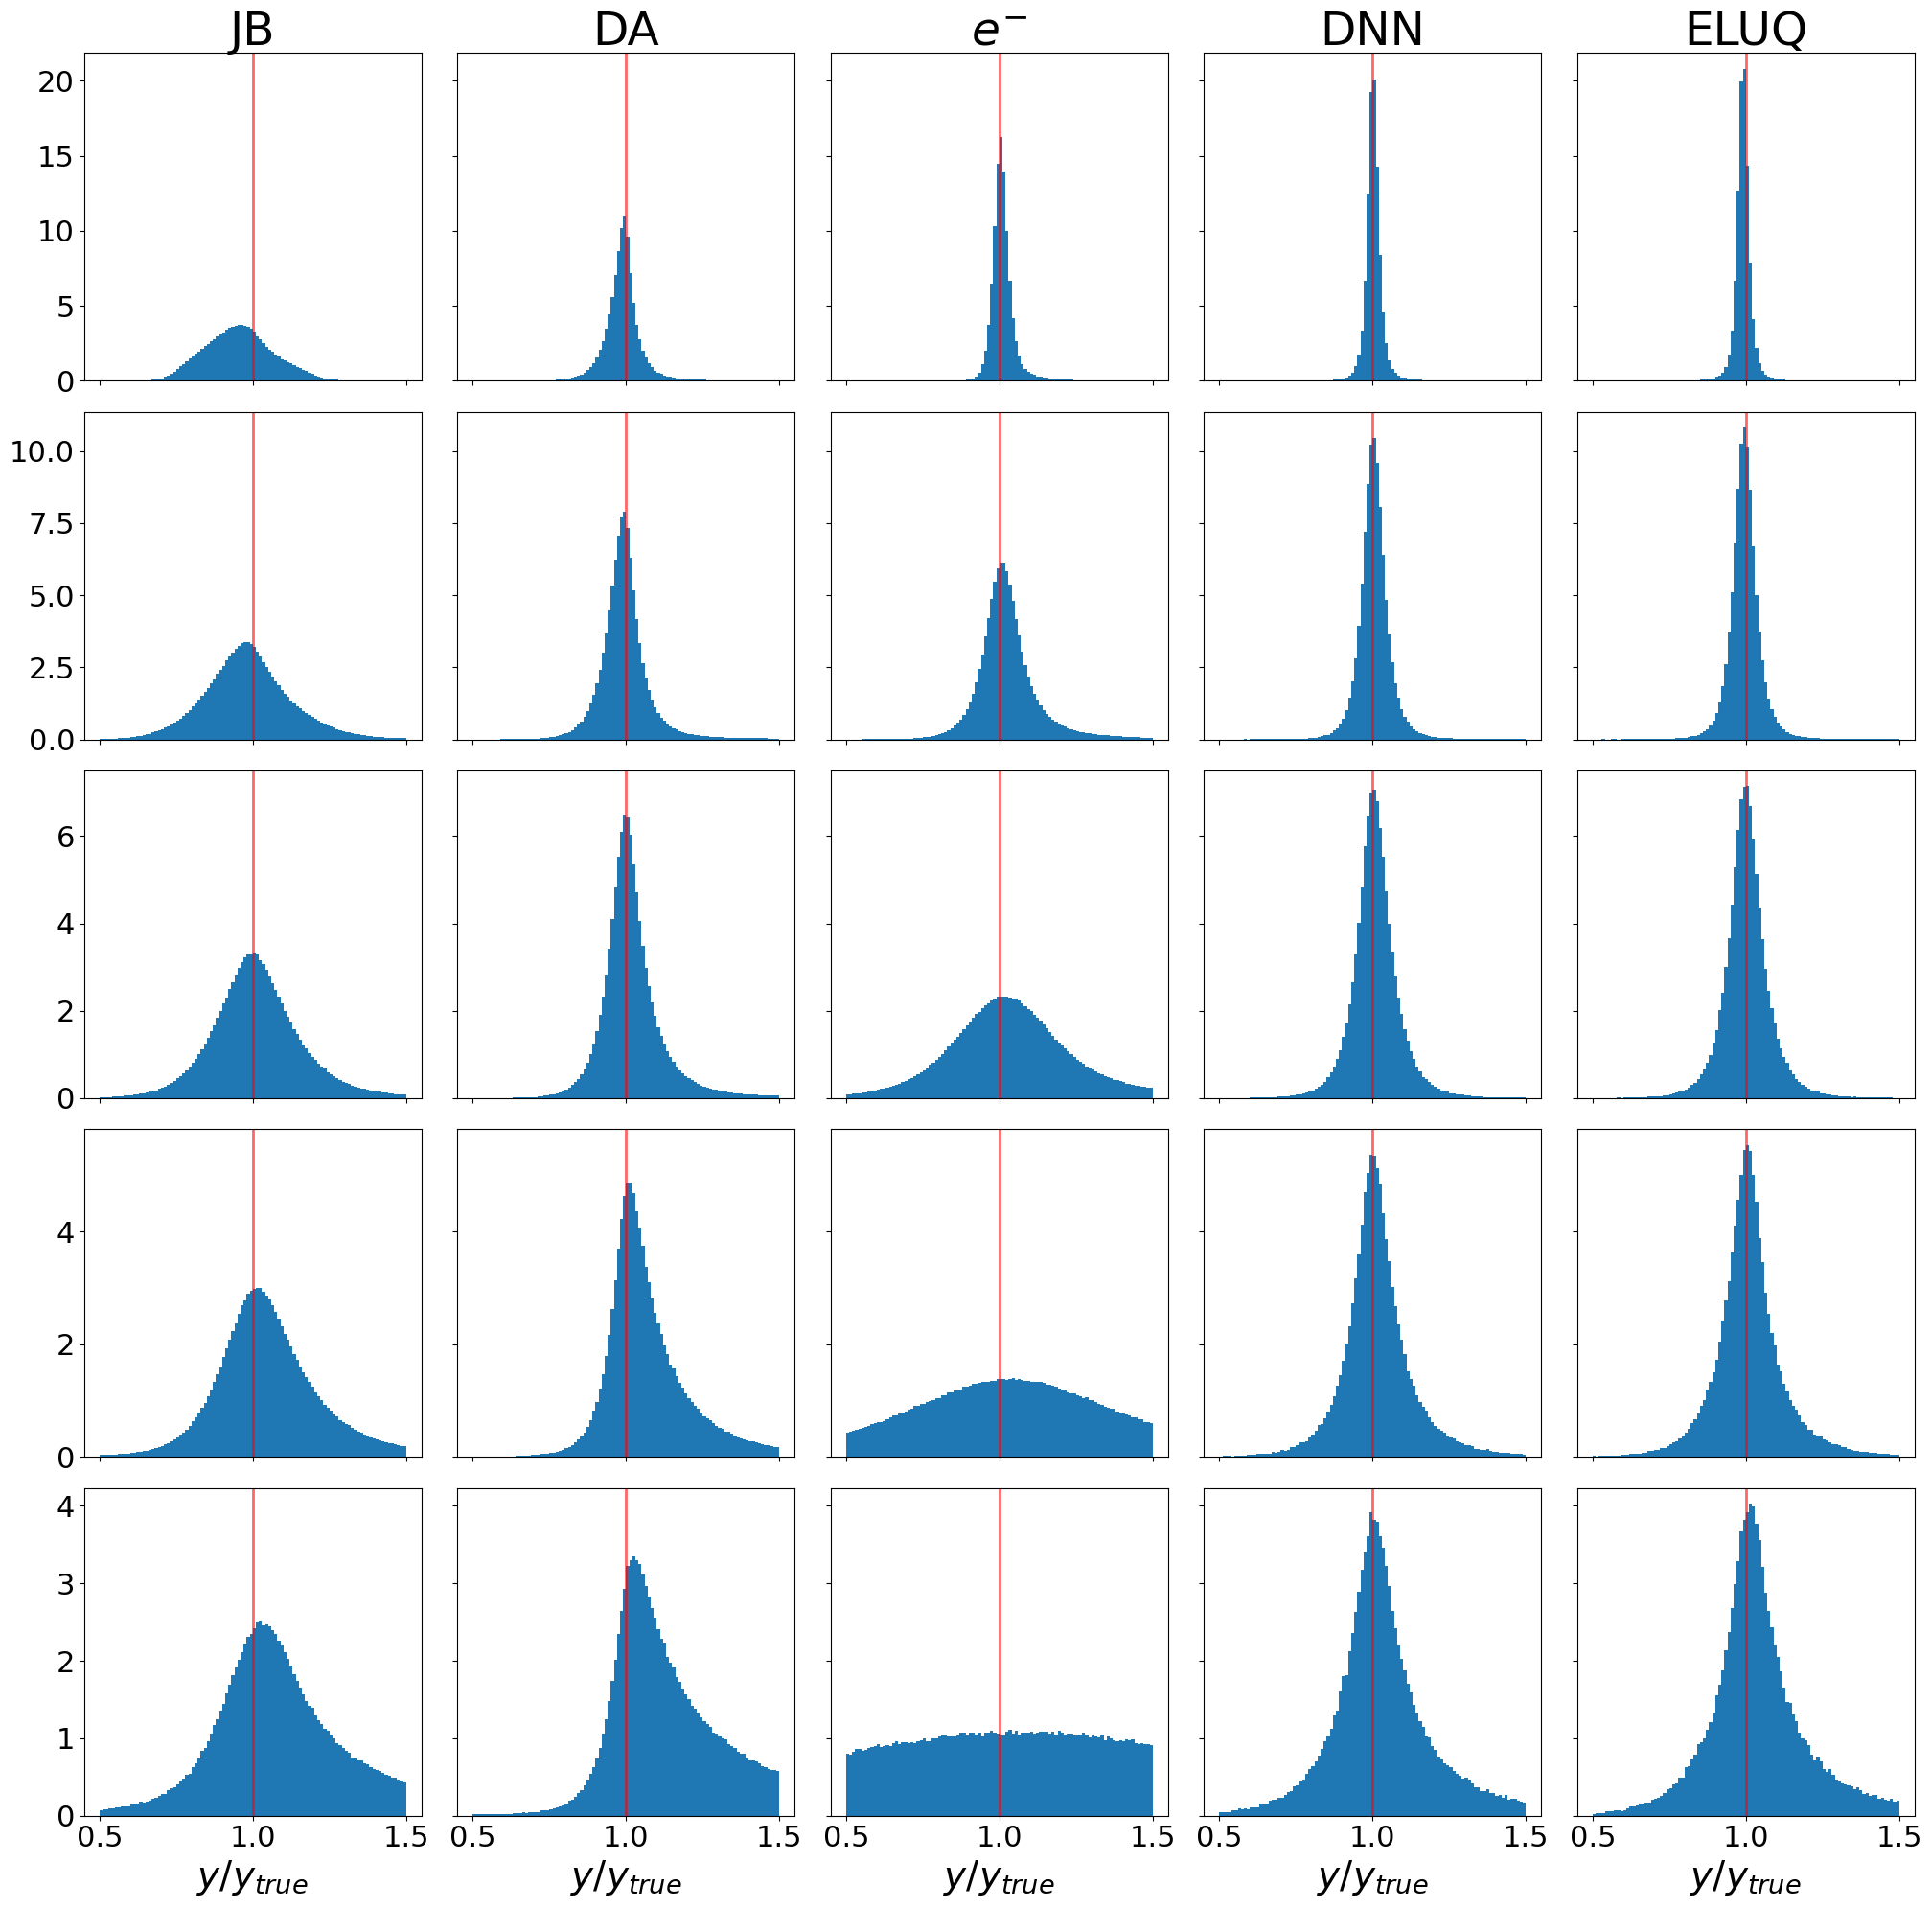

In [15]:
# y_ranges = [ (0.5, 0.8), (0.2, 0.5), (0.1, 0.2), (0.05, 0.1), (0.01, 0.05)] #---previously defined

mean_yratio = []
rms_yratio = []

methods_to_use = [4, 3, 0] # [5, 4, 3, 0]
methods_labels = ['JB', 'DA', r'$e^{-}$', 'Deep NN','MLP']#,'Error Weighting'] #'I$\Sigma$ method', 'Jacquet-Blondel', 'DA method', 'e method', 'Deep NN'
# H1 Values
xmin = 0.5
xmax = 1.5

# Athena Values
#xmin = 0.8
#xmax = 1.2
y_cut = ['from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80','from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50','from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20','from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10','from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05']

fig, ax = plt.subplots(len(y_cut), len(methods_labels), figsize=(20, 20), sharey='row', sharex=True)


# the standard methods
for i in range(len(methods_to_use)):
    mi = methods_to_use[i]
    for yi in range(len(y_cut)):
        counts, bin_edges, _ = ax[yi][i].hist(pandas_df.query(y_cut[yi])['obs_y[%d]' % mi] / pandas_df.query(y_cut[yi])['from_tlv_gen_y'],
                       density=True, bins=100, range=(xmin, xmax))
        if(yi==0):
          ax[yi][i].set_title(methods_labels[i],fontsize=35)

        mean_yratio, rms_yratio= cal_mean_rms(bin_edges,counts, mean_yratio, rms_yratio)


# the MLP method
for yi in range(len(y_cut)):
    counts, bin_edges, _ = ax[yi][len(methods_to_use)].hist(MLP_pred_vals[:, 2][(GY_test > y_ranges[yi][0]) * (GY_test < y_ranges[yi][1])] / true_vals[:, 2][(GY_test > y_ranges[yi][0]) * (GY_test < y_ranges[yi][1])],
                   density=True, bins=100, range=(xmin, xmax))
    ax[0][len(methods_to_use)].set_title('DNN',fontsize=35)

    mean_yratio, rms_yratio= cal_mean_rms(bin_edges,counts, mean_yratio, rms_yratio)
    
        
# the MNF method
for yi in range(len(y_cut)):
    counts, bin_edges, _ = ax[yi][len(methods_to_use)+1].hist(pred_vals[:, 2][(GY_test > y_ranges[yi][0]) * (GY_test < y_ranges[yi][1])] / true_vals[:, 2][(GY_test > y_ranges[yi][0]) * (GY_test < y_ranges[yi][1])],
                   density=True, bins=100, range=(xmin, xmax))
    ax[0][len(methods_to_use)+1].set_title(r'ELUQ',fontsize=35)

    mean_yratio, rms_yratio= cal_mean_rms(bin_edges,counts, mean_yratio, rms_yratio)

if(len(y_cut)>0):
    for i in range(len(methods_to_use)+2):
        ax[len(y_cut)-1][i].set_xlabel('$y/y_{true}$',fontsize=28)

for i in range(len(y_cut)):
    for j in range(len(methods_to_use)+2): # +1 to include DNN
        ax[i][j].axvline(1.0, color='red', lw=2, alpha=0.6)
        ax[i][j].tick_params(axis='y', labelsize=22)
        ax[i][j].tick_params(axis='x', labelsize=22)


plt.subplots_adjust(wspace=0.1, hspace=0.1)
#plt.savefig(r"save\path", format="pdf")
plt.show()
plt.close()

from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05


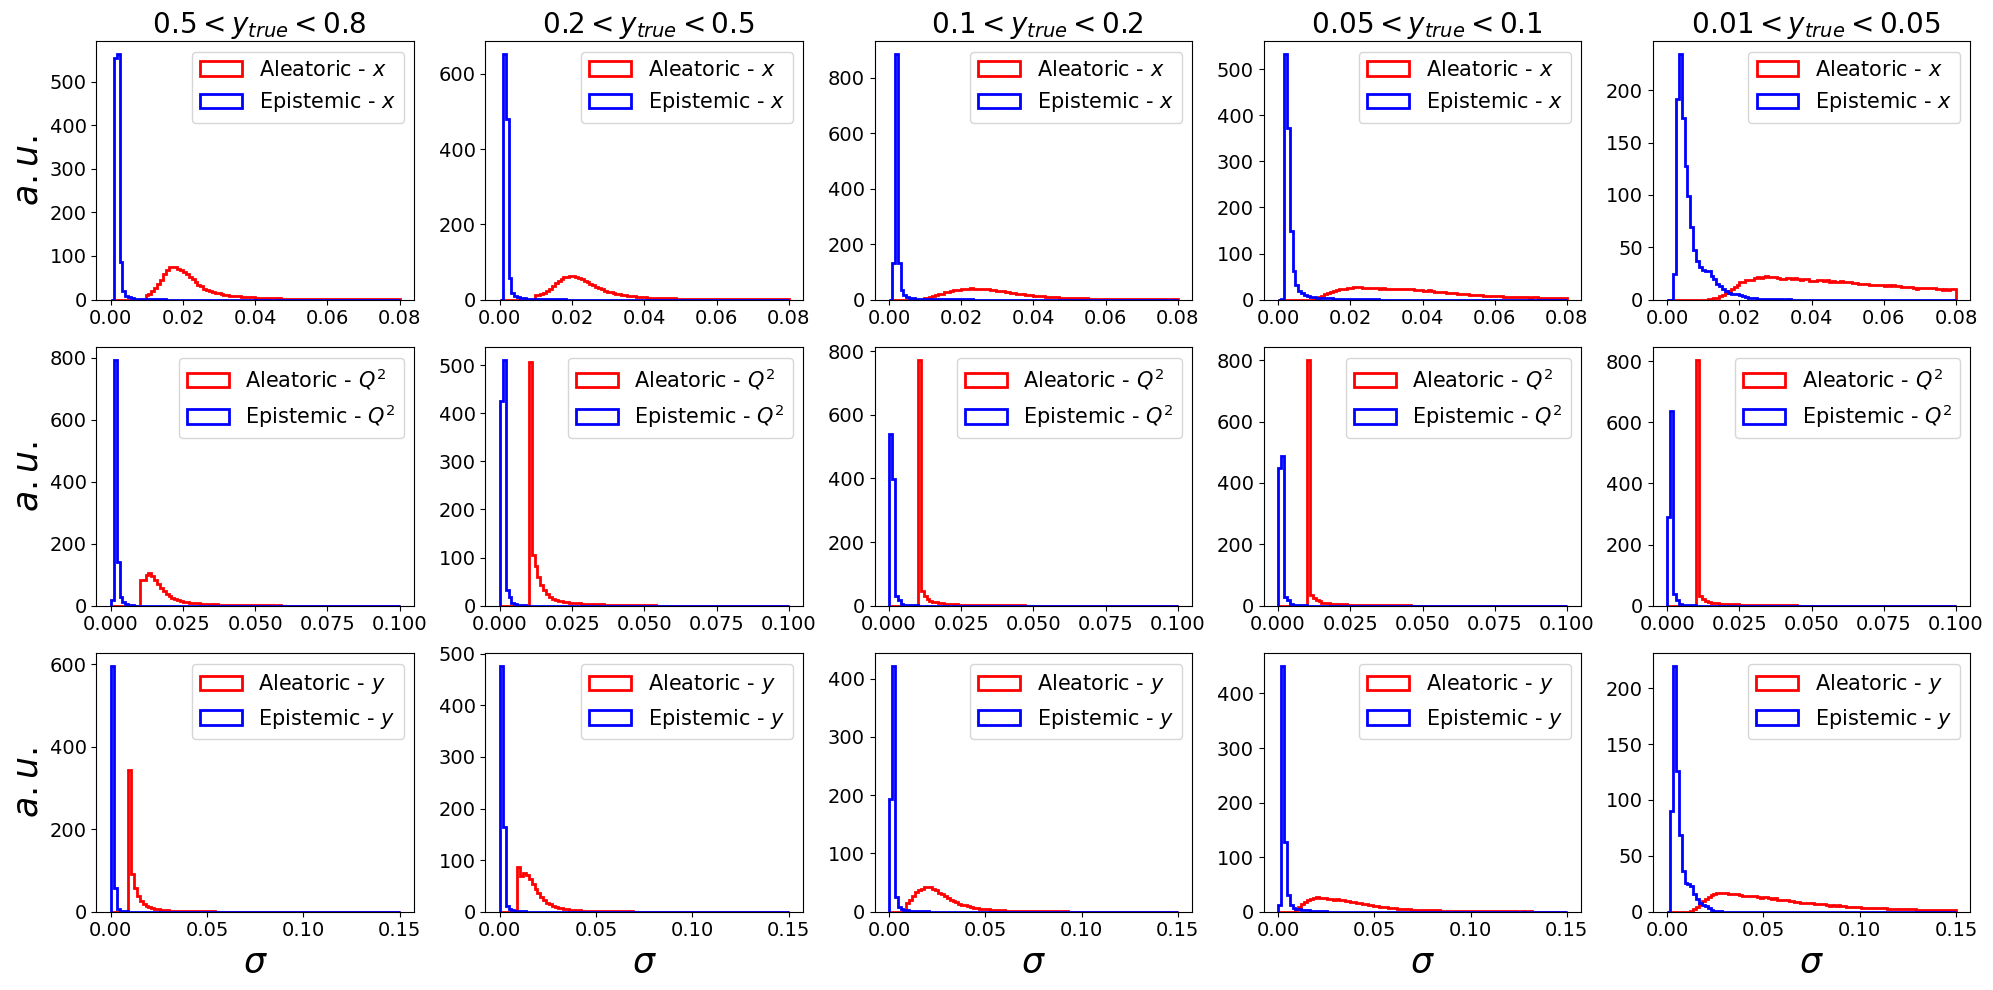

In [20]:
import matplotlib.pyplot as plt


fig,ax = plt.subplots(3,5,figsize=(20,10))

y_cut = ['from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80','from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50','from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20','from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10','from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05']
y_ranges = [ (0.5, 0.8), (0.2, 0.5), (0.1, 0.2), (0.05, 0.1), (0.01, 0.05)] #---previously defined

ykin = []
err_ykin = []

for values in y_ranges:
    tmp = 0.5*(values[0]+values[1])
    #print(values[0],values[1],tmp)
    ykin.append(tmp)
    tmp = abs(values[1]-values[0])
    err_ykin.append(tmp/np.sqrt(12.))

ykin = np.array(ykin)
err_ykin = np.array(err_ykin)

x_lims = [[0,0.01],[0,0.01],[0,.015],[0,.03],[0,0.07]]

for yi in range(len(y_cut)):
    print(y_cut[yi])
    y_range = y_ranges[yi]
    xr = [0,0.08]
    alea = aleatoric[:, 0][(GY_test > y_ranges[yi][0]) * (GY_test < y_ranges[yi][1])]
    epi = epistemic[:, 0][(GY_test > y_ranges[yi][0]) * (GY_test < y_ranges[yi][1])]
    ax[0][yi].hist(alea,bins=100,range=xr,color='red',lw=2,alpha=1.,label=r'Aleatoric - $x$',density=True,histtype='step')
    ax[0][yi].hist(epi,range=xr,bins=100,color='blue',lw=2,linestyle='-',alpha=1.,label=r'Epistemic - $x$',density=True,histtype='step')
    ax[0][yi].set_title(f' ${y_range[0]} < y_{{true}} < {y_range[1]}$',fontsize=20)
    ax[0][yi].legend(loc='best',fontsize=15)
    ax[0][yi].tick_params(axis='y', labelsize=14)
    ax[0][yi].tick_params(axis='x', labelsize=14)

    
    alea = aleatoric[:, 1][(GY_test > y_ranges[yi][0]) * (GY_test < y_ranges[yi][1])]
    epi = epistemic[:, 1][(GY_test > y_ranges[yi][0]) * (GY_test < y_ranges[yi][1])]
    ax[1][yi].hist(alea,bins=100,range=[0.,.1],color='red',lw=2,alpha=1.,label=r'Aleatoric - $Q^2$',density=True,histtype='step')
    ax[1][yi].hist(epi,range=[0,.1],bins=100,color='blue',lw=2,linestyle='-',alpha=1.,label=r'Epistemic - $Q^2$',density=True,histtype='step')
    ax[1][yi].legend(loc='best',fontsize=15)
    ax[1][yi].tick_params(axis='y', labelsize=14)
    ax[1][yi].tick_params(axis='x', labelsize=14)

    
    alea = aleatoric[:, 2][(GY_test > y_ranges[yi][0]) * (GY_test < y_ranges[yi][1])]
    epi = epistemic[:, 2][(GY_test > y_ranges[yi][0]) * (GY_test < y_ranges[yi][1])]
    ax[2][yi].hist(alea,bins=100,range=[0.,.15],color='red',lw=2,alpha=1.,label=r'Aleatoric - $y$',density=True,histtype='step')
    ax[2][yi].hist(epi,range=[0,.15],bins=100,color='blue',lw=2,linestyle='-',alpha=1.,label=r'Epistemic - $y$',density=True,histtype='step')
    ax[2][yi].legend(loc='best',fontsize=15)
    ax[2][yi].tick_params(axis='y', labelsize=14)
    ax[2][yi].tick_params(axis='x', labelsize=14)

    


ax[0][0].set_ylabel(r'$a.u.$',fontsize=25,rotation=90)
ax[1][0].set_ylabel(r'$a.u.$',fontsize=25,rotation=90)
ax[2][0].set_ylabel(r'$a.u.$',fontsize=25,rotation=90)

ax[-1][0].set_xlabel(r'$\sigma$',fontsize=25)
ax[-1][1].set_xlabel(r'$\sigma$',fontsize=25)
ax[-1][2].set_xlabel(r'$\sigma$',fontsize=25)
ax[-1][3].set_xlabel(r'$\sigma$',fontsize=25)
ax[-1][4].set_xlabel(r'$\sigma$',fontsize=25)
#plt.savefig(r"save\path", format="pdf",bbox_inches='tight')
plt.show()
plt.close()